# **Traffic Sign AI**

In [224]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [225]:
# Imports
%load_ext tensorboard
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from PIL import Image
import itertools

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [226]:
# Metadaten für das Programm 
data = []
labels = []
height = 30
width = 30
channels = 3
classes = 43
input_size = height * width * channels

In [227]:
# Verkehrsschilder 
sign_label = ["20 km/h","30 km/h","50 km/h","60 km/h","70 km/h","80 km/h","80 km/h Aufhebung","100 km/h",
          "120 km/h", "Überholverbot", "LKW-Überholverbot", "Vorfahrt", "Vorfahrtsstraße","Vorfahrt gewähren", 
          "Stop","Fahrverbot","Verbot für Lastwagen","Einfahrt verboten","Gefahr","Linkskurve","Rechtskurve","Doppelkurve",
          "Bodenwelle","Schleudergefahr","Verengung","Baustelle","Ampel","Zebrastreifen","Kinder","Fahrradweg","Schneegefahr",
          "Wildwechsel","Unbegrenzte Geschwindigkeit","Rechtsabbiegen", "Linksabbiegen", "Geradeaus fahren", "Geradeaus oder Rechtsabbiegen",
          "Geradeaus oder Linksabbiegen", "Hindernis rechts umfahren", " Hindernis links umfahren", "Kreisverkehr", "Ende des Überholverbotes",
          "Ende des LKW-Überholverbotes"]

In [228]:
# Einlesen der Bild-Datein
for i in range(classes):
    path = r".\Train\{0}/".format(i)
    print(path)
    Class = os.listdir(path)
    for a in Class:
        try:
            image = cv2.imread(path + a)
            image_from_array = Image.fromarray(image, 'RGB')
            size_image = image_from_array.resize((height, width))
            data.append(np.array(size_image))
            labels.append(i)
        except AttributeError:
            print(" ")

.\Train\0/
.\Train\1/
.\Train\2/
.\Train\3/
.\Train\4/
.\Train\5/
.\Train\6/
.\Train\7/
.\Train\8/
.\Train\9/
.\Train\10/
.\Train\11/
.\Train\12/
.\Train\13/
.\Train\14/
.\Train\15/
.\Train\16/
.\Train\17/
.\Train\18/
.\Train\19/
.\Train\20/
.\Train\21/
.\Train\22/
.\Train\23/
.\Train\24/
.\Train\25/
.\Train\26/
.\Train\27/
.\Train\28/
.\Train\29/
.\Train\30/
.\Train\31/
.\Train\32/
.\Train\33/
.\Train\34/
.\Train\35/
.\Train\36/
.\Train\37/
.\Train\38/
.\Train\39/
.\Train\40/
.\Train\41/
.\Train\42/


Gesamtzahl der Bilder: 39209


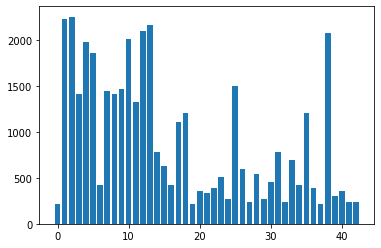

In [229]:
# Zusammenfassen aller Bilder in einem Array
Cells = np.array(data)
labels = np.array(labels)
print("Gesamtzahl der Bilder:",len(Cells))

# Darstellen der Bias des Datensets
from collections import Counter
c = Counter(labels)
plt.bar(c.keys(), c.values())
plt.show()

In [230]:
# Vermischen der Daten und Labels
s = np.arange(Cells.shape[0])
np.random.seed(43)
np.random.shuffle(s)
Cells = Cells[s]
labels = labels[s]

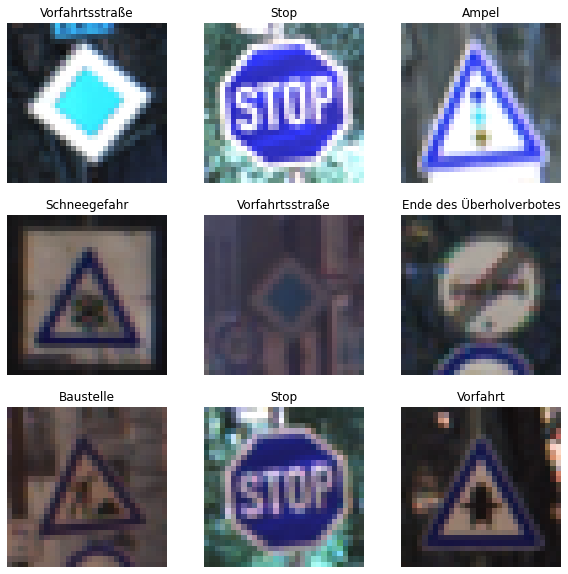

In [231]:
# Beispiele aus dem Dataset
fig=plt.figure(figsize=(10, 10))
columns = 3
rows = 3

for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(Cells[i])
    plt.title(sign_label[labels[i]])
    plt.axis("off")
plt.show()

In [232]:
# Aufteilen der Daten in ein Trainings- und ein Validierungsset
(x_train,x_val)=Cells[(int)(0.2*len(labels)):],Cells[:(int)(0.2*len(labels))]
x_train = x_train.astype('float32')/255
x_val = x_val.astype('float32')/255
(y_train,y_val)=labels[(int)(0.2*len(labels)):],labels[:(int)(0.2*len(labels))]

print("Größe des Trainingsets:    ",len(x_train))
print("Größe des Validierungssets:",len(x_val))

Größe des Trainingsets:     31368
Größe des Validierungssets: 7841


In [233]:
# Die Labels mit einem One-Hot-Encoder kategorisieren
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)

In [234]:
# Aufstellen des Netztes und Trainieren des Netztes

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
import datetime, os

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=x_train.shape[1:]))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))

# Kompilieren des Models 
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

epochs = 20
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model.fit(x_train, 
          y_train, 
          batch_size=32, 
          epochs=epochs,
          validation_data=(x_val, y_val), 
          callbacks = tensorboard_callback)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        2432      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 5, 5, 64)         

In [235]:

img = np.reshape(x_train[0:10], (10, height, width, 3))
file_writer = tf.summary.create_file_writer(logdir)
with file_writer.as_default():
      tf.summary.image("Training data", img, step=0)

In [236]:
# Starten des Tensorboards
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 19292), started 3:56:05 ago. (Use '!kill 19292' to kill it.)

In [237]:
# Laden der Test-Daten 
y_test=pd.read_csv(r'.\Test.csv')
names =y_test['Path'].to_numpy()
y_test =y_test['ClassId'].values
data=[]

In [238]:
from tqdm import tqdm
for f in tqdm(names):
    image=cv2.imread(r'.\Test/'+f.replace('Test', ''))
    image_from_array = Image.fromarray(image, 'RGB')
    size_image = image_from_array.resize((height, width))
    data.append(np.array(size_image))

100%|██████████| 12630/12630 [00:28<00:00, 448.04it/s]


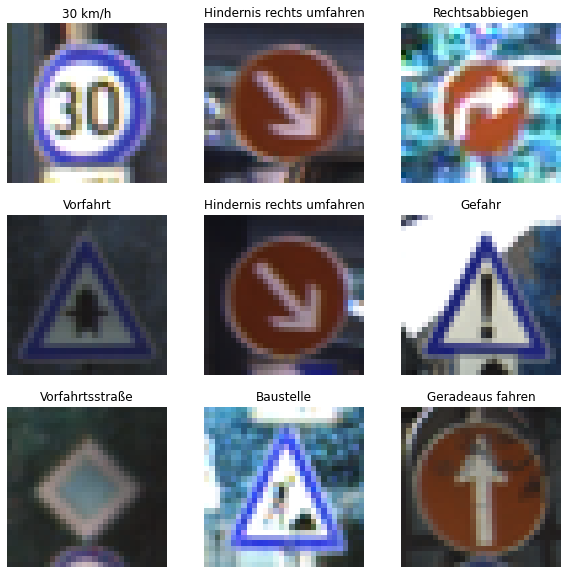

In [239]:
# Beispiele aus dem Test Dataset
fig=plt.figure(figsize=(10, 10))
columns = 3
rows = 3

for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(data[i])
    plt.title(sign_label[y_test[i]])
    plt.axis("off")
plt.show()

In [248]:
x_test=np.array(data)
x_test = x_test.astype('float32')/255
pred = model.predict(x_test)

In [249]:
meta_data=[]
for f in range(42):
    image=cv2.imread("./Meta/"+str(f)+".png")
    image_from_array = Image.fromarray(image, 'RGB')
    meta_data.append(np.array(image_from_array))    

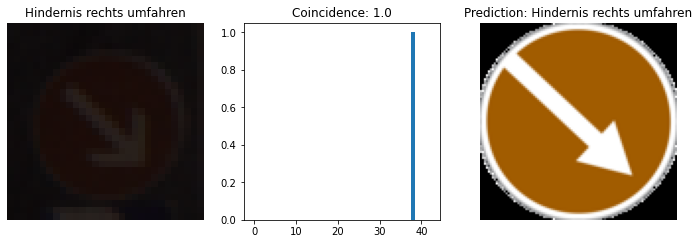

In [251]:
x = 1320

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize = (12, 12))

y = [i for i in range(len(sign_label))]

ax1.imshow(data[x])
ax2.bar(y, pred[x])
ax3.imshow(meta_data[np.argmax(pred[x])])

asp = np.diff(ax2.get_xlim())[0] / np.diff(ax2.get_ylim())[0]
ax2.set_aspect(asp)

ax1.axis("off")
ax3.axis("off")

ax1.title.set_text(sign_label[y_test[x]])
ax2.title.set_text("Coincidence: "+ str(max(pred[x])))
ax3.title.set_text("Prediction: "+sign_label[np.argmax(pred[x])])
plt.show()